### Longformer-base model

Transformer-based models are unable to process long sequences due to their self-attention operation, which scales quadratically with the sequence length. To address this limitation,
the Longformer model was introduced with an attention mechanism that scales linearly with sequence
length, making it easy to process documents of thousands of tokens or longer. Longformer’s
attention mechanism is a drop-in replacement for the standard self-attention and combines a local windowed attention with a task motivated global attention.

With this serving as a suppliment for validating the performance of the hybrid approach, I have used a Huggingfac Model - longformer-base-4096 - for the same.

In [2]:
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import *
from glob import glob
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
VER=14 
LOAD_TOKENS_FROM = '../input/tf-longformer-v12'
LOAD_MODEL_FROM = '../input/tflongformerv14'
DOWNLOADED_MODEL_PATH = None

if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'
MODEL_NAME = 'allenai/longformer-base-4096'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('../input/project/train.csv')
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

#The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
train_txt = glob('../input/project/train/*.txt') 
test_txt = glob('../input/project/test/*.txt')

In [6]:
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))
cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

train.query('discourse_len != pred_len')[cols_to_display]

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


There exists instances where the predictionstring is not equivalent to the length of the grouping, which shouldn't be the same. Something to look into the split() function used while pre-processing.

I want to inspect if there is a correlation between the length of each of these groupings and its respective the classes?

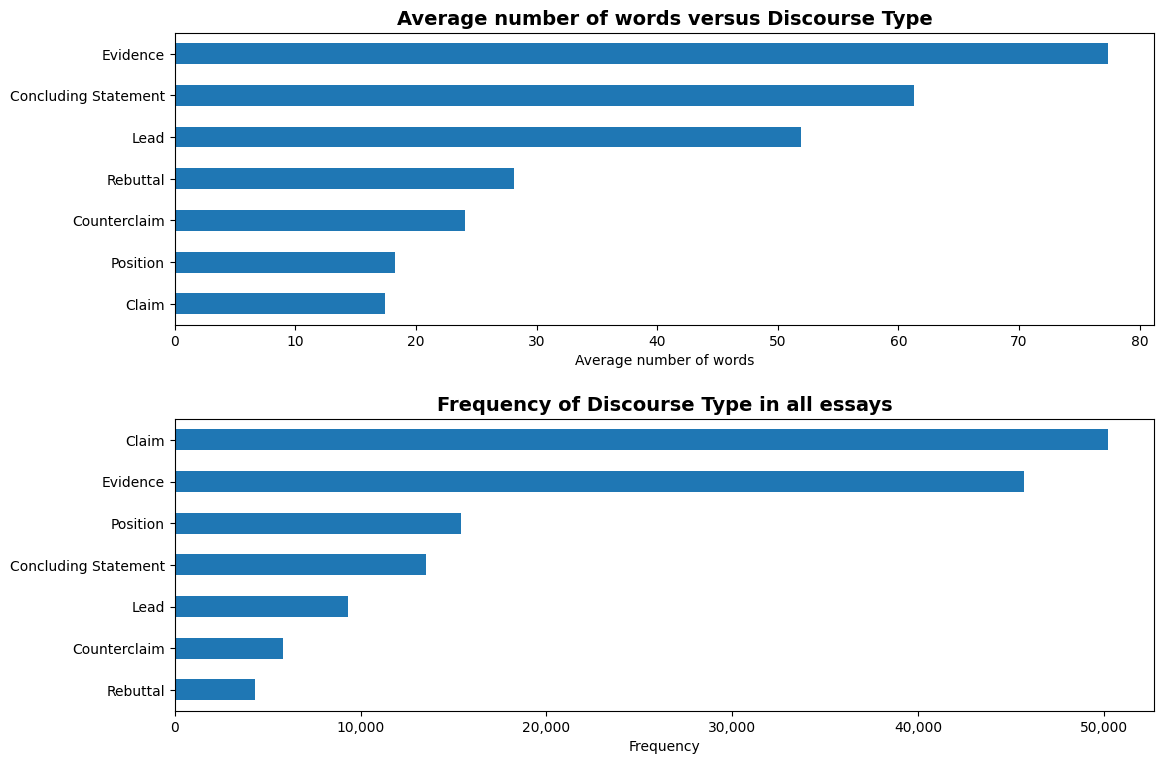

In [7]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = train.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

Yes, there is. Evidence is the longest discount type on average. When looking at the frequencies of occurence, we see that Counterclaim and Rebuttal are relatively rare.

I want to now visualize how each of these groupings based on discourses would look in an actual essay. So let's use a visualization package displacy to render these.

In [35]:
def render(r):
    ents = []
    for i, row in train[train['id'] == train_txt[r][35:-4]].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(train_txt[r], 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
    }

    colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
    options = {"ents": train.discourse_type.unique().tolist(), "colors": colors}
    return spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

In [36]:
render(239)

In [40]:
render(1234)

In [34]:
render(2332)

To start, I manually searched for the most frequently used single words. I changed all of the text to lowercase and removed stopwords, but I kept the punctuation. Additionally, I removed a few unnecessary words that were scattered throughout the discourse_type figures. I wasn't sure how helpful this would be after all of this work. Rebuttal frequently uses the word "however," which is one thing to note.

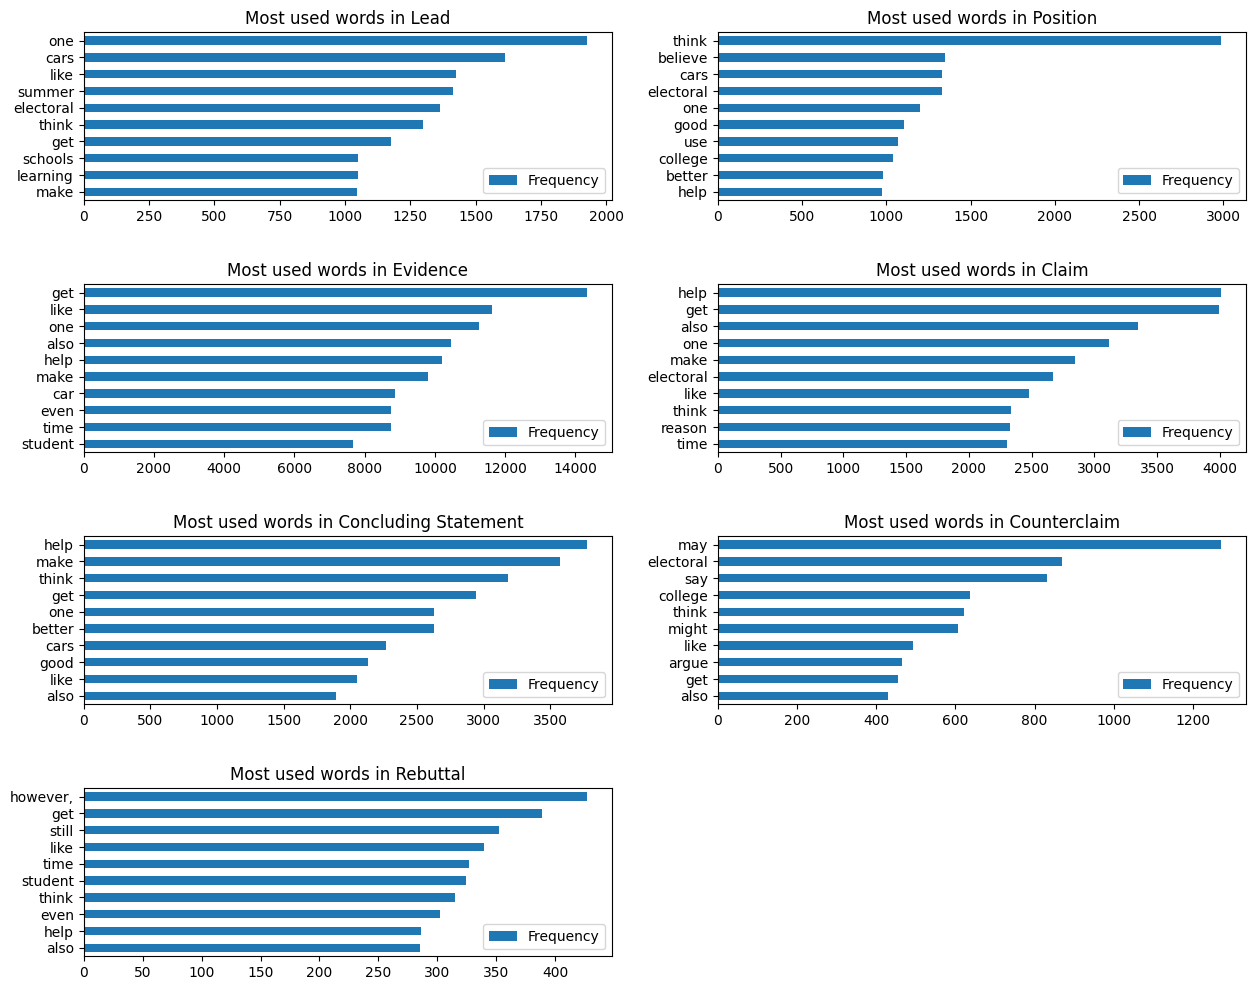

In [8]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put dataframe of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

In [10]:
DOWNLOADED_MODEL_PATH

'model'

I've downloaded the longformer-base-4096 model along with it's associated config files.

In [12]:
if DOWNLOADED_MODEL_PATH == 'model':
    os.mkdir('model')
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained('model')
    config = AutoConfig.from_pretrained(MODEL_NAME) 
    config.save_pretrained('model')
    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    backbone.save_pretrained('model')
    print("YES")

Could not locate the tokenizer configuration file, will try to use the model config instead.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/config.json
Model config LongformerConfig {
  "_name_or_path": "allenai/longformer-base-4096",
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "onnx_export": false,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "transformers_version": "4.35.0",
  "type_vocab_size": 1,
  "voc

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/config.json
Model config LongformerConfig {
  "_name_or_path": "allenai/longformer-base-4096",
  "attention_mode": "longformer",
  "attention_probs_dropout_prob

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--allenai--longformer-base-4096/snapshots/301e6a42cb0d9976a6d6a26a079fef81c18aa895/tf_model.h5
Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongfor

YES


In [13]:
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
train = pd.read_csv('../input/project/train.csv')
IDS = train.id.unique()

single strategy


In [14]:
MAX_LEN = 1024
tokenizer = AutoTokenizer.from_pretrained('model')
train_tokens = np.zeros((len(IDS),MAX_LEN), dtype='int32')
train_attention = np.zeros((len(IDS),MAX_LEN), dtype='int32')
lead_b = np.zeros((len(IDS),MAX_LEN))
lead_i = np.zeros((len(IDS),MAX_LEN))
position_b = np.zeros((len(IDS),MAX_LEN))
position_i = np.zeros((len(IDS),MAX_LEN))
evidence_b = np.zeros((len(IDS),MAX_LEN))
evidence_i = np.zeros((len(IDS),MAX_LEN))
claim_b = np.zeros((len(IDS),MAX_LEN))
claim_i = np.zeros((len(IDS),MAX_LEN))
conclusion_b = np.zeros((len(IDS),MAX_LEN))
conclusion_i = np.zeros((len(IDS),MAX_LEN))
counterclaim_b = np.zeros((len(IDS),MAX_LEN))
counterclaim_i = np.zeros((len(IDS),MAX_LEN))
rebuttal_b = np.zeros((len(IDS),MAX_LEN))
rebuttal_i = np.zeros((len(IDS),MAX_LEN))

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [15]:
assert( np.sum(train.groupby('id')['discourse_start'].diff()<=0)==0 )

for id_num in range(len(IDS)):
    if LOAD_TOKENS_FROM: break
    if id_num%100==0: print(id_num,', ',end='')
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = IDS[id_num]
    name = f'../input/project/train/{n}.txt'
    txt = open(name, 'r').read()
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids']
    train_attention[id_num,] = tokens['attention_mask']
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets = tokens['offset_mapping']
    offset_index = 0
    df = train.loc[train.id==n]
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        if offset_index>len(offsets)-1:
            break
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        beginning = True
        while b>c:
            if (c>=a)&(b>=d):
                k = target_map[row.discourse_type]
                if beginning:
                    targets_b[k][id_num][offset_index] = 1
                    beginning = False
                else:
                    targets_i[k][id_num][offset_index] = 1
            offset_index += 1
            if offset_index>len(offsets)-1:
                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]

In [16]:
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
    for k in range(7):
        targets[:,:,2*k] = targets_b[k]
        targets[:,:,2*k+1] = targets_i[k]
    targets[:,:,14] = 1-np.max(targets,axis=-1)

In [17]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_LEN}', targets)
    np.save(f'tokens_{MAX_LEN}', train_tokens)
    np.save(f'attention_{MAX_LEN}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_LEN}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_LEN}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_LEN}.npy')
    print('Loaded NER tokens')

Loaded NER tokens


In [18]:
def build_model():
    
    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json') 
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model

In [19]:
with strategy.scope():
    model = build_model()

loading configuration file model/config.json
Model config LongformerConfig {
  "_name_or_path": "model/config.json",
  "architectures": [
    "LongformerModel"
  ],
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "onnx_export": false,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "transformers_version": "4.35.0",
  "type_vocab_size": 1,
  "vocab_size": 50265
}

loading weights file model/tf_model.h5
All model checkpoint layers were used when 

In [20]:
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))
EPOCHS = 5
BATCH_SIZE = 4 
LRS = [0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-5] 
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

Train size 14034 , Valid size 1560


In [21]:
if LOAD_MODEL_FROM:
    model.load_weights(f'{LOAD_MODEL_FROM}/long_v{VER}.h5')
    
else:
    train_tokens_device = tf.constant(train_tokens[train_idx,]).cpu()
    train_attention_device = tf.constant(train_attention[train_idx,]).cpu()
    valid_tokens_device = tf.constant(train_tokens[valid_idx,]).cpu()
    valid_attention_device = tf.constant(train_attention[valid_idx,]).cpu()
    model.fit(
        x=[train_tokens_device, train_attention_device],
        y=targets[train_idx,],
        validation_data=(
            [valid_tokens_device, valid_attention_device],
            targets[valid_idx,]
        ),
        callbacks=[lr_callback],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=2
    )
    model.save_weights(f'long_v{VER}.h5')

In [22]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
oof_preds = np.argmax(p,axis=-1)
target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}

98/98 - 185s - 185s/epoch - 2s/step


In [38]:
def get_preds(dataset='train', verbose=True, text_ids=IDS[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
        name = f'../input/project/{dataset}/{n}.txt' # Get Token positions
        txt = open(name, 'r').read()
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(txt[i]!='\xa0')&(txt[i]!='\x85')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n')|(txt[i]=='\xa0')|(txt[i]=='\x85'):
                blank=True
        w.append(1e6)
        word_map = -1 * np.ones(MAX_LEN,dtype='int32') #Tokens to words mapping
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_LEN:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_LEN: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_LEN: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    return df
oof = get_preds( dataset='train', verbose=True, text_ids=IDS[valid_idx] )

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 

Similar to the other file - hybrid approach

In [ ]:
def calc_overlap(row):
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]

In [39]:
def score_feedback_comp(pred_df, gt_df):
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score


In [40]:
oof

,id,class,predictionstring
0,50B3435E475B,Lead,3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20...
1,50B3435E475B,Position,63 64 65 66 67 68 69 70 71 72 73 74 75
2,50B3435E475B,Claim,76 77 78 79 80 81 82 83 84 85 86 87
3,50B3435E475B,Evidence,88 89 90 91 92 93 94 95 96 97 98 99 100 101 10...
4,50B3435E475B,Claim,162 163 164 165 166 167 168 169 170 171 172 17...
...,...,...,...
12570,D0131DAC0F63,Claim,66 67 68 69 70 71 72 73
12571,D0131DAC0F63,Evidence,74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 8...
12572,D0131DAC0F63,Evidence,235 236 237 238 239 240 241 242 243 244 245 24...
12573,D0131DAC0F63,Evidence,342 343 344 345 346 347 348 349 350 351 352 35...


In [41]:
valid = train.loc[train['id'].isin(IDS[valid_idx])]
f1s = []
CLASSES = oof['class'].unique()
for c in CLASSES:
    pred_df = oof.loc[oof['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

Lead 0.8063284233496999
Position 0.6841560234725578
Claim 0.6057328285559762
Evidence 0.6816788493279887
Concluding Statement 0.7827050997782705
Counterclaim 0.4854732895970009
Rebuttal 0.39030955585464333

Overall 0.6337691528480197
